# Decision theory and supervised learning
### **Week 1**-STAT 348 (Spring 2024)

#### Relevant materials / reading:
- Materials for L1-L3 of Matthew Stephens' course: [STAT 348 (Spring 2021)](https://dynalist.io/d/ehiGZbaDzYG4q9tJvuCrag3U#z=Hu-cB8VnWnu5IXOgZ-3MaF6C)

- Chap 2 of [Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/)

- Chap 2 of [An Introduction to Statistical Learning with Applications in Python](https://www.statlearning.com/)

- Chap 3 and 12 of [Advanced Data Analysis
from an Elementary Point of View](https://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/ADAfaEPoV.pdf)
----

## **Two class** prediction problem
- Patients have symptoms $X \in \mathbb{R}^p$

- Patients are either diseased or not $Y \in \{0,1\}$

----
## Sample of **data** from the population
- $(X_i, Y_i) \stackrel{\textrm{iid}}{\sim} \textrm{Pr}(X, Y),\,\,\, i=1,\dots, n$

- Goal: learn to predict $Y$ from $X$

- This is a **supervised learning** problem

In [1]:
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# full data set
# df_full = pd.read_csv('dat/disease_data.csv')
# df_full

# short data set (only two binary features)
df = pd.read_csv('dat/disease_data_short.csv')
df

,Y_disease,X1_fever,X2_cough
0,0,0,0
1,0,1,1
2,1,1,1
3,0,1,1
4,0,1,0
...,...,...,...
9995,1,0,1
9996,0,1,1
9997,0,1,1
9998,0,1,0


#### Contingency table
- $Y$ and $X$ in this case are binary

- It is easy to **estimate** $\textrm{Pr}(y,\, x)$ for all $(y, x)$ values by simply counting

- (Note that $\textrm{Pr}(y, x)$ is a property of the **population**)

- We will use $P(y,x)$ to refer to our sample frequency, or any other model-based estimate of $\textrm{Pr}(y, x)$

In [2]:
df.value_counts(normalize=True).reset_index(name='frequency')

,Y_disease,X1_fever,X2_cough,frequency
0,0,1,1,0.4908
1,0,1,0,0.2729
2,0,0,1,0.1044
3,1,1,1,0.0661
4,0,0,0,0.0573
5,1,1,0,0.0060
6,1,0,1,0.0024
7,1,0,0,0.0001


----
## **Likelihood**
- New patient has symptoms $X=x$

- Are they diseased $(Y=1)$ or not $(Y=0)$?

- Calculate the **likelihood of the data under** $Y=1$ vs 0
$$P(X=x \mid Y=1)$$
$$\textrm{vs}$$
$$P(X=x \mid Y=0)$$

- These are also known as **class conditional probabilities** for prediction problems

In [3]:
class_conditional_0 = df[df['Y_disease']==0].value_counts(normalize=True).reset_index(name='class_conditional_frequency')
class_conditional_1 = df[df['Y_disease']==1].value_counts(normalize=True).reset_index(name='class_conditional_frequency')

print(class_conditional_1.to_string(index=False))
print(class_conditional_0.to_string(index=False))

 Y_disease  X1_fever  X2_cough  class_conditional_frequency
         1         1         1                     0.886059
         1         1         0                     0.080429
         1         0         1                     0.032172
         1         0         0                     0.001340
 Y_disease  X1_fever  X2_cough  class_conditional_frequency
         0         1         1                     0.530365
         0         1         0                     0.294900
         0         0         1                     0.112816
         0         0         0                     0.061919


New patient presents with a fever and cough...
$$P(X^{\textrm{fever}}=1,\, X^{\textrm{cough}}=1 \mid Y=1) = 0.886059$$
$$\textrm{vs}$$
$$P(X^{\textrm{fever}}=1,\, X^{\textrm{cough}}=1 \mid Y=0) = 0.530365$$

### Likelihood ratios
- Defined as:
$$\textrm{LR} = \frac{P(X=x \mid Y=1)}{P(X=x \mid Y=0)}$$

- In this case, $\tfrac{0.886059}{0.530365}\approx 1.7$

- **Symptoms are 1.7x more likely** under $Y=1$ than $Y=0$

### Continuous features
- Much of the same logic holds if $X$ is continuous

- $P(X=x \mid Y=y)$ was a class-conditional probability for discrete $X$

- $P(X=x \mid Y=y)$ is now a class-conditional density for continuous $X$

In [4]:
df_cont = pd.read_csv('dat/disease_data_continuous.csv'); df_cont

,Y_disease,X11_systolic_BP
0,0,113.589200
1,0,121.742896
2,1,122.323603
3,0,119.631718
4,0,114.605352
...,...,...
9995,1,124.859778
9996,0,105.611849
9997,0,141.819443
9998,0,103.975723


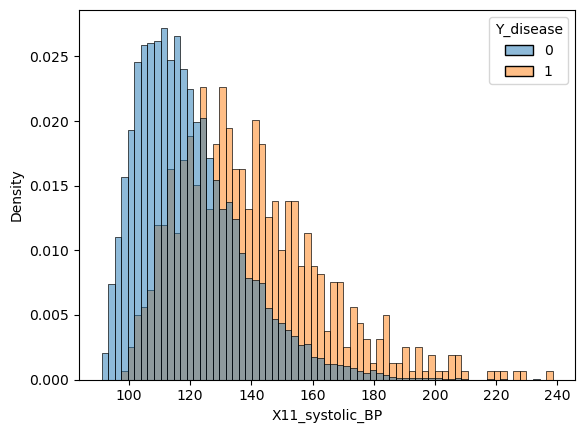

In [5]:
_ = sns.histplot(data=df_cont, x='X11_systolic_BP', hue='Y_disease', stat='density', common_norm=False)

### Assuming a parametric family
- We can't directly compute frequencies for all unique $(x,y)$ in the data

- Instead we can fit a simple distribution to the data from each class

- In other words we **assume** the class-conditional density is a member of a parametric family 

$$\textrm{Pr}(X^{\textrm{systolic-BP}} \mid Y=y) = P_\Theta(X^{\textrm{systolic-BP}};\, \theta_y)$$ 
where $\theta_y \in \Theta$ is the parameter for class $y \in \{0,1\}$ which "indexes" into this family.


#### Assuming Gaussian densities
- For continuous data, a simple default assumption is Gaussian:
$$\textrm{Pr}(X^{\textrm{systolic-BP}} \mid Y=y) = \mathcal{N}(X^{\textrm{systolic-BP}};\, \mu_y,\,\sigma_y)$$

- We can find the two Gaussians via maximum likelihood:
$$\widehat{\mu}_0, \widehat{\sigma}_0 \leftarrow \underset{\mu_0, \sigma_0}{\textrm{argmax}} \prod_{i:\, y^{\textrm{disease}}_i=0} \mathcal{N}(x^{\textrm{systolic-BP}}_i;\,\, \mu_0,\,\, \sigma_0)$$
$$\widehat{\mu}_1, \widehat{\sigma}_1 \leftarrow \underset{\mu_1, \sigma_1}{\textrm{argmax}} \prod_{i:\, y^{\textrm{disease}}_i=1} \mathcal{N}(x^{\textrm{systolic-BP}}_i;\,\, \mu_1,\,\, \sigma_1)$$

In [6]:
def get_class_conditional_densities(df, feature, label, family=st.norm):
    """ Fits the class conditional densities for a given feature and label.

    Args:
        df (pd.DataFrame): the dataframe containing the data
        feature (str): the feature column (X)
        label (str): the label column (Y)
        family (scipy.stats distribution class): the distribution family to use 
            (default: st.norm, a normal distribution)
    
    Returns: 
        a tuple scipy.stats distribution objects, one for each class
    """
    values_1 = df[df[label]==1][feature].values
    values_0 = df[df[label]==0][feature].values
    class_conditional_dist_1 = family(*family.fit(values_1))
    class_conditional_dist_0 = family(*family.fit(values_0))
    return class_conditional_dist_1, class_conditional_dist_0

In [7]:
class_conditional_norm_1, class_conditional_norm_0 = get_class_conditional_densities(df=df_cont, 
                                                                                     feature='X11_systolic_BP', 
                                                                                     label='Y_disease', 
                                                                                     family=st.norm)

In [8]:
def plot_fitted_densities_over_histograms(df, feature, label, class_conditional_dist_1, class_conditional_dist_0):
    """ Plots the fitted class-conditional densities over the histograms of the feature for each class.

    Args:
        df (pd.DataFrame): the dataframe containing the data
        feature (str): the feature column (X)
        label (str): the label column (Y)
        class_conditional_dist_1 (scipy.stats distribution object): the fitted class-conditional distribution for Y=1
        class_conditional_dist_0 (scipy.stats distribution object): the fitted class-conditional distribution for Y=0
    """
    values_1 = df[df[label]==1][feature].values
    values_0 = df[df[label]==0][feature].values
    sns.histplot(data=df, x=feature, hue=label, kde=False, bins=20, stat='density', common_norm=False)

    # calculate the range of the x-axis
    min_val = min(values_1.min(), values_0.min())
    max_val = max(values_1.max(), values_0.max())
    x_axis_vals = np.linspace(min_val-10, max_val+10, 500)

    # plot the fitted densitites over the histograms
    plt.plot(x_axis_vals, class_conditional_dist_1.pdf(x_axis_vals), label='$Y=1$', color='orange', lw=3, linestyle='--')
    plt.plot(x_axis_vals, class_conditional_dist_0.pdf(x_axis_vals), label='$Y=0$', color='blue', lw=3, linestyle='--')
    plt.title(f'Fitted class-conditional densities for {feature}')
    plt.legend()
    plt.show()

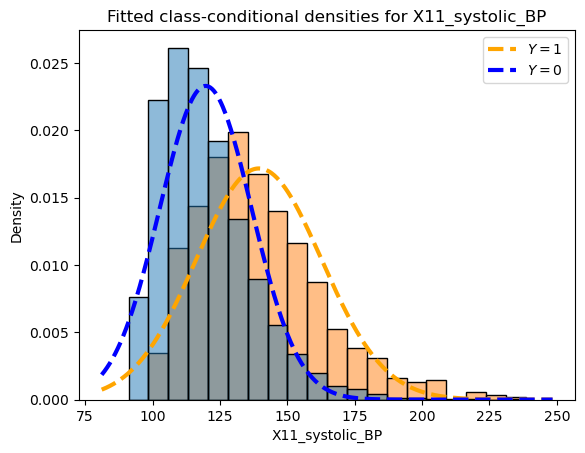

In [9]:
plot_fitted_densities_over_histograms(df=df_cont, 
                                      feature='X11_systolic_BP',
                                      label='Y_disease', 
                                      class_conditional_dist_1=class_conditional_norm_1,
                                      class_conditional_dist_0=class_conditional_norm_0)

### Likelihood ratios (with PDFs)
- Defined the same as before:
$$\textrm{LR} = \frac{P(X=x \mid Y=1)}{P(X=x \mid Y=0)}$$
- Using our fitted Gaussians:
$$\textrm{LR} = \frac{\mathcal{N}(X=x;\, \widehat{\mu}_1,\,\widehat{\sigma}_1)}{\mathcal{N}(X=x;\, \widehat{\mu}_0,\,\widehat{\sigma}_0)}$$

In [10]:
x = 125
LR = class_conditional_norm_1.pdf(x) / class_conditional_norm_0.pdf(x)
print(f'Patient\'s systolic BP of {x} is {round(LR, 2)}x more likely with disease Y=1 than not Y=0.')

Patient's systolic BP of 125 is 0.64x more likely with disease Y=1 than not Y=0.


### Assuming a different parametric family: Gamma
- The normal is symmetric, which perhaps does not fit this data well

- We could instead fit two [gamma distributions](https://en.wikipedia.org/wiki/Gamma_distribution) (including with location parameters)

$$\widehat{\alpha}_y, \, \widehat{\beta}_y, \, \widehat{\ell}_y \, \leftarrow \underset{\alpha_y, \, \beta_y, \, \ell_y}{\textrm{argmax}} \prod_{i:\, y^{\textrm{disease}}_i=y} \textrm{Gamma}(x^{\textrm{systolic-BP}}_i;\,\, \textrm{shape}=\alpha_y, \, \textrm{rate}=\beta_y, \, \textrm{loc}=\ell_y)$$


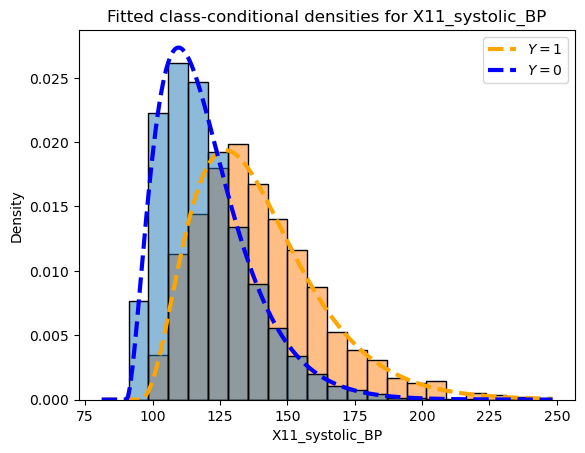

In [11]:
class_conditional_gamma_1, class_conditional_gamma_0 = get_class_conditional_densities(df=df_cont, 
                                                                                       feature='X11_systolic_BP', 
                                                                                       label='Y_disease', 
                                                                                       family=st.gamma)

plot_fitted_densities_over_histograms(df=df_cont, 
                                      feature='X11_systolic_BP',
                                      label='Y_disease', 
                                      class_conditional_dist_1=class_conditional_gamma_1,
                                      class_conditional_dist_0=class_conditional_gamma_0)

#### Different modeling assumptions can lead to different conclusions

In [12]:
x = 125
LR = class_conditional_norm_1.pdf(x) / class_conditional_norm_0.pdf(x)
print(f'Patient\'s systolic BP of {x} is {round(LR, 2)}x more likely with disease Y=1 than not Y=0 under Gaussian model.')
LR = class_conditional_gamma_1.pdf(x) / class_conditional_gamma_0.pdf(x)
print(f'Patient\'s systolic BP of {x} is {round(LR, 2)}x more likely with disease Y=1 than not Y=0 under Gamma model.')

Patient's systolic BP of 125 is 0.64x more likely with disease Y=1 than not Y=0 under Gaussian model.
Patient's systolic BP of 125 is 1.05x more likely with disease Y=1 than not Y=0 under Gamma model.


----
### Brief interlude: **modeling philosophy**
- Modeling assumptions are typically necessary in practice to make progress

- ["All models are wrong but some are useful"](https://en.wikipedia.org/wiki/All_models_are_wrong) -George Box

- ["Box's Loop"](https://xuwd11.github.io/am207/wiki/boxloop.html): 

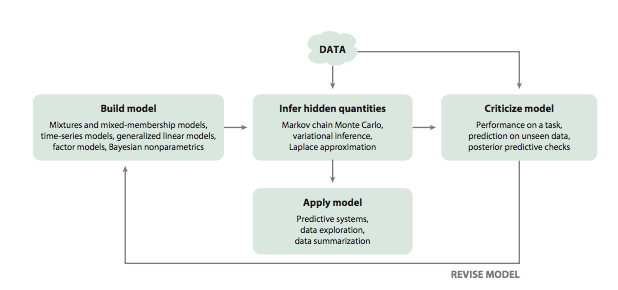

----

## **Prior**
- Is a likelihood ratio of e.g., $\textrm{LR}=2$ enough for us to predict $Y=1$?

- That means: **likelihood of observed data $X$ are 2x more likely under $Y=1$**

- But, **what is the base rate of $Y=1$?** 

- e.g., some diseases are very rare in the population

$$\textrm{Pr}(Y=1)=?$$

- Prior = "before seeing any data"

- When $Y$ is discrete, it's easy to obtain an estimate $P(Y=1)$

In [13]:
prior_1 = df['Y_disease'].mean()
print(f'Base rate of Y=1 in training data: {prior_1:.2f}')

Base rate of Y=1 in training data: 0.07


----
## **Posterior**
- The right question is: **how probable is the disease given symptoms $x$**?

$$\textrm{Pr}(Y=1 \mid X=x) = ?$$
- "Posterior" = "after seeing data"

- According to **Bayes rule** it equals
$$\begin{align} 
\textrm{Pr}(Y=1 \mid X=x) &= \frac{\overbrace{\textrm{Pr}(X=x \mid Y=1)}^{\textrm{likelihood}} \,\, \overbrace{\textrm{Pr}(Y=1)}^{\textrm{prior}}}{\underbrace{\textrm{Pr}(X=x)}_{\textrm{normalizing constant}}}
\end{align}
$$
- The term $\textrm{Pr}(X=x)$ is **constant** with respect to $Y$

- Also known as the "marginal likelihood" (among other terms)
$$\textrm{Pr}(X=x) = \sum_{y} \underbrace{\textrm{Pr}(Y=y \mid X=x)}_{\textrm{likelihood}} \,\,\underbrace{\textrm{Pr}(Y=y)}_{\textrm{prior}}$$

- If we have (model-based) estimates of the likelihood and prior, $P(Y \mid X)$ and $P(Y)$, then we can **"do Bayesian inference"** to get a (model-based estimate of) the posterior by plugging in.

- Often the normalizing constant is hard to calculate...

### Posterior odds
- For any probability $p$, the **odds** are $\frac{p}{1-p}$
- The posterior odds are: $$\textrm{Posterior Odds} = \frac{\textrm{Pr}(Y=1 \mid X=x)}{\textrm{Pr}(Y=0 \mid X=x)}$$
- Useful formula (derive on board): $$\textrm{Posterior Odds} = \textrm{Prior Odds} \times \textrm{Likelihood ratio}$$
- This avoids calculation of the normalizing constant (which cancels out)

#### Example

- Using the example above of $P(Y=1)=0.07$... $$\textrm{Prior Odds} = \frac{0.07}{0.93} \approx 0.075$$
- So, even if data are 2x more likely under $Y=1$...
$$\textrm{Posterior Odds} = \frac{0.07}{0.93} \times 2 \approx 0.15 $$
- ... $Y=1$ **is still much less likely** (0.15x) than $Y=0$ given the observed data.

----
## **Loss function**
- We have a posterior $P(Y=1 \mid X=x)$

- But is that enough to make a **decision** $\widehat{Y} \in \{0,1\}$?

- In some settings, false negatives are more **costly** than false positives

- e.g., a deadly disease with an easy cure

- We need to know about the **loss function**:
$$\ell(y,\,\widehat{y})$$
- For binary prediction problems, this is a $2 \times 2$ table:

|                  | $\widehat{y}=0$   | $\widehat{y}=1$    |
| --------         | ------- |  ------- |
| $y=0$  | $\ell(0,0) \equiv \ell_{\textrm{TN}}$   | $\ell(0,1) \equiv \ell_{\textrm{FP}}$|
| $y=1$  | $\ell(1,0) \equiv \ell_{\textrm{FN}}$     | $\ell(1,1) \equiv \ell_{TP}$|

- TN = True negative
- TP = True positive
- FN = False negative
- FP = False positive

- The diagonals (correct) should not be greater than the off-diagonals (errors)

- But perhaps the off-diagonal are (very) unequal, e.g. $$\ell_{FN} \gg \ell_{FP}$$

### Decision rule
- A decision rule $\widehat{Y}(\cdot)$ here is a function of data that outputs a prediction $$\widehat{Y}(X) \in \{0,1\}$$
- An example would be:
$$\begin{align}
\widehat{Y}(X) = \begin{cases}
1 &\textrm{if } P(Y=1 \mid X=x) \geq 0.5\\
0 &\textrm{otherwise }
\end{cases}
\end{align}
$$
- Note that this rule might not be optimal for our loss function

-----
## **Risk**
- The **integrated risk** of a decision rule $\widehat{Y}(\cdot)$ is
$$r\Big(\widehat{Y}(\cdot)\Big) = \mathbb{E}_{X,Y}\left[\ell\Big(Y, \widehat{Y}(X)\Big)\right]$$
- Conceptually, this averages over infinite draws $(X_i,Y_i) \stackrel{\textrm{iid}}{\sim} \textrm{Pr}(X,Y)$,  $i=1,2,\dots$ from the population

- This is a frequentist criterion

#### Bayes risk
- An important result (prove on board) is that the best possible rule is
$$\widehat{Y}^*(x) =\underset{a}{\textrm{argmin}} \, \mathbb{E}_{Y \mid X=x}[\ell(a, Y)]$$

- That is, the one that always minimizes the **conditional expected loss** for any value of $X=x$

- This is known as the **Bayes decision rule**

- Its risk is known as the **Bayes risk**

- Why "Bayes"? Because it is **based only on $\textrm{Pr}(Y \mid X)$**

- In other words if you knew the **true** prior $\textrm{Pr}(Y)$ and likelihood $\textrm{Pr}(X \mid Y)$, then doing Bayesian inference is the best you can do

- Often cited as a frequentist motivation for Bayesian inference

- Not (necessarily) true if you only have (model-based) estimates of likelihood and prior

#### Common loss functions and their Bayes decision rules
- **Squared loss** (typical for continuous $Y$)
$$\begin{align}
\nonumber
\ell(y, \hat{y}) &= (y-\widehat{y})^2 \\
\nonumber
\widehat{Y}^*(x) &= \mathbb{E}[Y \mid X=x]
\end{align}
$$
- **Absolute loss** (typical for continuous $Y$)
$$\begin{align}
\nonumber
\ell(y, \hat{y}) &= |y-\widehat{y}| \\
\nonumber
\widehat{Y}^*(x) &= \textrm{Median}[Y \mid X=x]
\end{align}
$$
- **0-1 loss** (typical for categorical $Y$)
$$\begin{align}
\nonumber
\ell(y, \hat{y}) &= \mathbb{1}(y=\widehat{y}) \\
\nonumber
\widehat{Y}^*(x) &= \underset{a}{\textrm{argmax}} \,P(Y=a \mid X=x)
\end{align}
$$

-----
## **Generative** versus **discriminative** approaches
- Theory tells us the optimal decision rule is based on $\textrm{Pr}(Y \mid X)$

- The **generative** approach to supervised learning is to **model** $\textrm{Pr}(Y)$ and $\textrm{Pr}(X \mid Y)$ and then do Bayesian inference

- The **discriminative** approach is to **model** $\textrm{Pr}(Y \mid X)$ *directly*

### **Generative approach**
- When $Y$ is discrete (e.g., binary), it's easy to model the prior $\textrm{Pr}(Y)$

- Generally $\textrm{Pr}(X \mid Y)$ is the hard part...

- e.g., high-dimensional $X$

In [14]:
df_full = pd.read_csv('dat/disease_data.csv')
# include only the discrete features (first 10 columns) for simplicity
df_full = df_full[df_full.columns[:11]]
df_full

,Y_disease,X1_fever,X2_cough,X3_fatigue,X4_headache,X5_loss_of_taste,X6_loss_of_smell,X7_chest_pain,X8_breathing_difficulty,X9_abdominal_pain,X10_nausea
0,0,0,0,1,0,0,1,1,1,0,1
1,0,1,1,0,0,0,0,1,1,0,0
2,1,1,1,1,0,0,0,1,1,0,1
3,0,1,1,1,0,0,0,1,1,0,0
4,0,1,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,1,1,0,1,1,1,1,1,0
9996,0,1,1,1,0,0,0,1,1,0,0
9997,0,1,1,1,0,1,0,1,1,1,0
9998,0,1,0,0,0,0,0,1,1,0,0


- Try estimating $P(X = x \mid Y=y)$ using the basic counting / contingency table approach from before

In [15]:
df_full.value_counts(normalize=True).reset_index(name='frequency')

,Y_disease,X1_fever,X2_cough,X3_fatigue,X4_headache,X5_loss_of_taste,X6_loss_of_smell,X7_chest_pain,X8_breathing_difficulty,X9_abdominal_pain,X10_nausea,frequency
0,0,1,1,0,0,0,0,1,1,0,0,0.0796
1,0,1,1,1,0,0,0,1,1,0,0,0.0585
2,0,1,1,0,0,0,0,1,1,1,0,0.0466
3,0,1,0,0,0,0,0,1,1,0,0,0.0388
4,0,1,1,1,0,0,0,1,1,1,0,0.0349
...,...,...,...,...,...,...,...,...,...,...,...,...
631,0,0,1,0,0,1,0,1,1,1,1,0.0001
632,0,1,1,1,0,1,1,1,1,1,1,0.0001
633,0,1,1,1,1,0,0,0,0,0,1,0.0001
634,0,0,1,0,0,1,0,0,1,0,1,0.0001


- Notice there are 636 rows out of $2^{11} = 2048$ possible values of $x,y$

- Most rows are based on only a single data point

- Data **sparsity**

### Naive Bayes
- To deal with sparsity, we can make the following modeling **assumption**:
$$\textrm{Pr}(X_1=x_1,\dots,X_p=x_p \mid Y=y) = \prod_{j=1}^p \textrm{Pr}(X_j = x_j \mid Y=y)$$
- In other words, **the features are conditionally independent** given the class label

- Why is this useful? All we have to do now is model each factor $\textrm{Pr}(X_j = x_j \mid Y=y)$

- e.g., for discrete $X_j$, just count (as above)


In [16]:
df_full[['Y_disease', 'X1_fever']].value_counts(normalize=True).reset_index(name='frequency')

,Y_disease,X1_fever,frequency
0,0,1,0.7637
1,0,0,0.1617
2,1,1,0.0721
3,1,0,0.0025


- Or for continuous $X$, fit a density (e.g., Gaussian, as before)

- The (modeled) posterior can be easily computed (do on board)

$$P(Y=1 \mid X_1=x_1,\dots,X_p=x_p) = \cdots$$

- This assumption is **naive** (almost always wrong)

- e.g., is is plausible that **loss of smell** and **loss of taste** are conditionally independent?

- Naive Bayes is nevertheless often effective (all models wrong, some useful)

### **Discriminative approach**

- Since the generative approach often requires (naive) modeling assumptions about $\textrm{Pr}(X \mid Y)$...

- ...why not just model $\textrm{Pr}(Y \mid X)$ directly?

- e.g., assume $\textrm{Pr}(Y \mid X)$ is a member of a (non-)parametric family, and find the best-fitting member

### Logistic regression
- The default parametric approach for binary $Y$

- Assume that:
$$
\log \frac{\textrm{Pr}(Y=1 \mid X=x)}{\textrm{Pr}(Y=0 \mid X=x)} = \beta_0 + \beta^\top x
$$
- In words, assume that the log-odds of $\textrm{Pr}(Y=1 \mid X=x)$ is a **linear function** of $x$

- The log-odds of a probability $p$ is also called the $\textrm{logit}(p)$.

- This assumption is equivalent to

$$\begin{align}
\textrm{Pr}(Y=1 \mid X=x) = \textrm{logit}^{-1}\Big(\beta_0 + \beta^\top x\Big) = \frac{1}{1-e^{-(\beta_0 + \beta^\top x)}}
\end{align}
$$
- Again, naive but often effective

- For notational simplicity / clarity we can say
$$\begin{align}
p(x; \beta_0, \beta) \triangleq \textrm{logit}^{-1}\Big(\beta_0 + \beta^\top x\Big)
\end{align}
$$


#### Fitting with maximum likelihood and convex optimization
- Closed-form solution is not available (unlike in linear regression)

- The likelihood of the data under the model is $$P\left((x_i,y_i)_{i=1}^n;\, \beta_0, \beta\right) = \prod_{i=1}^n \left[p(x_i; \beta_0, \beta)\right]^{y_i} \,\, \left[1-p(x_i; \beta_0, \beta)\right]^{1-y_i}$$

- Fit using maximum likelihood $$\widehat{\beta}_0, \widehat{\beta} \leftarrow \underset{\beta_0,\beta}{\textrm{argmax}} \prod_{i=1}^n \left[p(x_i; \beta_0, \beta)\right]^{y_i} \,\, \left[1-p(x_i; \beta_0, \beta)\right]^{1-y_i}$$

- In practice, we typically minimize the negative log-likelihood
$$\widehat{\beta}_0, \widehat{\beta} \leftarrow \underset{\beta_0,\beta}{\textrm{argmin}} \left[-\sum_{i: y_i=1}\log p(x_i; \beta_0, \beta) - \sum_{i: y_i=0} \log [1-p(x_i; \beta_0, \beta)]\right]$$
- This is known as the **cross entropy loss** function

- Can be minimized numerically using convex optimizers e.g., Newton-Raphson, L-BGFS, ...

#### Fitting logistic regression with [scikit-learn](https://scikit-learn.org/stable/)

In [17]:
from sklearn.preprocessing import StandardScaler

# use the full data set (both discrete and continuous features)
df_full = pd.read_csv('dat/disease_data.csv')

# include only the feature (not outcome) columns
feature_cols = [col for col in df_full.columns if col != 'Y_disease']

# scale the features
scaler = StandardScaler()
scaler.fit(df_full[feature_cols])
df_full[feature_cols] = scaler.transform(df_full[feature_cols]) # subtract means and divide by stds

df_full

,Y_disease,X1_fever,X2_cough,X3_fatigue,X4_headache,X5_loss_of_taste,X6_loss_of_smell,X7_chest_pain,X8_breathing_difficulty,X9_abdominal_pain,X10_nausea,X11_systolic_BP,X12_diastolic_BP
0,0,-2.256133,-1.404826,1.095988,-0.403808,-0.547924,2.557631,0.303415,0.316019,-0.754074,2.584665,-0.411464,-0.175894
1,0,0.443236,0.711832,-0.912419,-0.403808,-0.547924,-0.390987,0.303415,0.316019,-0.754074,-0.386897,0.031642,0.868490
2,1,0.443236,0.711832,1.095988,-0.403808,-0.547924,-0.390987,0.303415,0.316019,-0.754074,2.584665,0.063200,-0.273356
3,0,0.443236,0.711832,1.095988,-0.403808,-0.547924,-0.390987,0.303415,0.316019,-0.754074,-0.386897,-0.083088,-0.184274
4,0,0.443236,-1.404826,1.095988,-0.403808,-0.547924,-0.390987,0.303415,0.316019,-0.754074,-0.386897,-0.356242,2.246311
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,-2.256133,0.711832,1.095988,-0.403808,1.825070,2.557631,0.303415,0.316019,1.326130,-0.386897,0.201027,1.151158
9996,0,0.443236,0.711832,1.095988,-0.403808,-0.547924,-0.390987,0.303415,0.316019,-0.754074,-0.386897,-0.844987,-0.842043
9997,0,0.443236,0.711832,1.095988,-0.403808,1.825070,-0.390987,0.303415,0.316019,1.326130,-0.386897,1.122687,-0.027634
9998,0,0.443236,-1.404826,-0.912419,-0.403808,-0.547924,-0.390987,0.303415,0.316019,-0.754074,-0.386897,-0.933901,-0.290728


#### Splitting train-test 

- Define a random 70-30 **train-test split** of our sample

- This let's us **model** the out-of-sample error (again, under assumptions)

- Fit a logistic regression model to the train split, assess error on test data

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as logreg

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_full[feature_cols], 
                                                    df_full['Y_disease'], 
                                                    test_size=0.3)

# fit a logistic regression model
model = logreg(penalty='none', fit_intercept=True, solver='lbfgs')
model.fit(X_train, y_train)

# predict on the test set
y_pred = model.predict(X_test)

# calculate the accuracy
accuracy = (y_pred == y_test).mean()
print(accuracy)


0.9473333333333334


In [32]:
# scikit-learn's predict versus predict_proba function
model.predict_proba(X_test)

array([[0.79074289, 0.20925711],
       [0.82333761, 0.17666239],
       [0.97965084, 0.02034916],
       ...,
       [0.99818779, 0.00181221],
       [0.96484546, 0.03515454],
       [0.89259897, 0.10740103]])

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as logreg

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_full[feature_cols], 
                                                    df_full['Y_disease'], 
                                                    test_size=0.3)

# fit a logistic regression model
model = logreg(penalty='none', fit_intercept=True, solver='lbfgs')
model.fit(X_train, y_train)

# predict on the test set
y_pred = model.predict(X_test)

# calculate the accuracy
accuracy = (y_pred == y_test).mean()
print(accuracy)


0.945


- Accuracy doesn't tell the full story

- Recall that only 7\% of the sample are diseased ($Y=1$)

- Visualize the **confusion matrix**

[[2758   25]
 [ 140   77]]


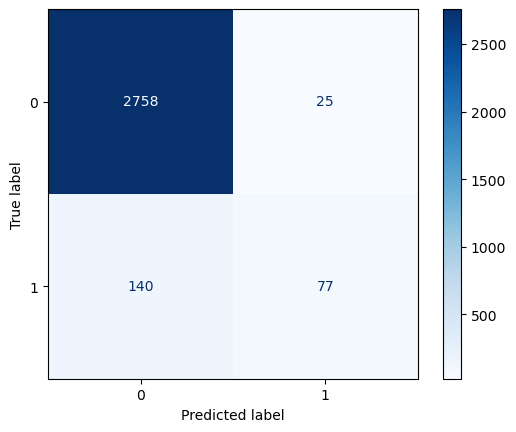

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# plot the confusion matrix using blue scheme
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
_ = disp.plot(cmap='Blues')

#### (**LECTURE 1** ended here.)
----

#### Optimal threshold

- `model.predict` will output 0,1 using a 0.5 threshold to make decisions

- `model.predict_proba` will output the model's posterior probability $\widehat{p}(x) \triangleq \textrm{logit}^{-1}\Big(\widehat{\beta}_0 + \widehat{\beta}^\top x\Big)$

- Say we are given the following loss function where **false positives (FP) are more costly** than false negatives (FN):

|                  | $\widehat{y}=0$   | $\widehat{y}=1$    |
| --------         | ------- |  ------- |
| $y=0$  | $\ell_{\textrm{TN}} = 1$   | $\ell_{\textrm{FP}} = 11$|
| $y=1$  | $\ell_{\textrm{FN}} = 2$     | $\ell_{\textrm{TP}} = 1$|

- Holding fixed the trained model, how should we threshold its predicted probabilities to make decisions?

- For a given input $x$, we should predict $\widehat{Y}(x)=1$ if:
$$\widehat{p}(x) > \frac{\ell_{\textrm{FP}} - \ell_{\textrm{TN}}}{\ell_{\textrm{FP}} - \ell_{\textrm{TN}} + \ell_{\textrm{FN}} - \ell_{\textrm{TP}}}$$

- [Prove on board]

- This appeals to the fact that (default) logistic regression yields models which are **well-calibrated**---i.e.,
$$\textrm{Pr}(Y=1 \mid \widehat{p}(x)=p) = p$$

In [35]:
# hard-code losses and calculate threshold
loss_TN = 0; loss_FP = 10
loss_FN = 1; loss_TP = 0

thresh = (loss_FP - loss_TN) / (loss_FP - loss_TN + loss_FN - loss_TP)
# thresh = 0.5  # comment in to compare

# get test probabilities and apply threshold
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba > thresh).astype(int)

# calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix using blue scheme
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# _ = disp.plot(cmap='Blues')

# calculate test prediction loss
test_pred_loss = (cm * np.array([[loss_TN, loss_FP],
                                 [loss_FN, loss_TP]])).sum()

print(f'Using prediction threshold of {thresh:.2f}, the test prediction loss is {test_pred_loss}.')

Using prediction threshold of 0.91, the test prediction loss is 216.


#### AUC and ROC
- Changing the threshold changes the trade-off between the **true positive and false positive rates**:

$$
\begin{align}
\textrm{TPR} &= \frac{\textrm{number of true positives}}{\textrm{number of positive labels}} = \frac{\sum_{i=1}^n y_i \, \widehat{Y}(x_i)}{\sum_{i=1}^n y_i} \\
\textrm{FPR} &= \frac{\textrm{number of false positives}}{\textrm{number of negative labels}} = \frac{\sum_{i=1}^n (1-y_i) \, \widehat{Y}(x_i)}{\sum_{i=1}^n (1-y_i)}
\end{align}
$$

- We can visualize this trade-off across different thresholds with the **receiver-operator characteristic (ROC) curve**

- The **area under the ROC curve (AUC)** is then a way to evaluate the model, taking all thresholds into account

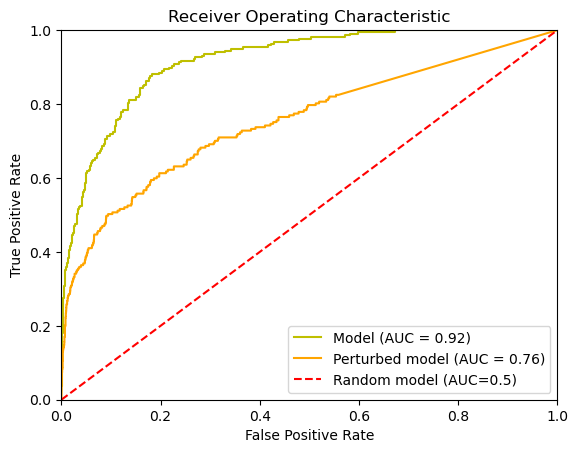

In [36]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# plot the ROC curve for the model and calculate AUC
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr) 
plt.plot(fpr, tpr, 'y', label='Model (AUC = %0.2f)' % roc_auc)

# perturb the model probabilities randomly and re-plot
y_proba = model.predict_proba(X_test)[:, 1] + np.random.normal(0, 0.25, len(y_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_proba.clip(0,1))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='orange', label='Perturbed model (AUC = %0.2f)'%roc_auc)

# a completely random classifier will lie along the diagonal
plt.plot([0, 1], [0, 1],'r--', label='Random model (AUC=0.5)')

plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic')
plt.xlim([0, 1]), plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Decision boundary
- Logistic regression learns a **linear** decision boundary

- With the default prediction threshold of $\textrm{logit}^{-1}(\beta_0 + \beta^\top x) > 0.5$, we will predict 1 when $$\beta_0 + \beta^\top x > 0$$

<img src="img/640px-Logistic-curve.svg.png" width="400" height="">


In [37]:
def fit_and_plot_decision_boundary(df, model, feature_cols, label_col):
    """ Fits a model and plots the decision boundary for a binary classification problem.

    Args:
        df (pd.DataFrame): the dataframe containing the data
        model (scikit-learn model): the model to fit
        feature_cols (list of str): the feature columns (X)
        label_col (str): the label column (Y)
    """
    # fit the model
    model.fit(df[feature_cols], df[label_col])

    # calculate accuracy
    y_pred = model.predict(df[feature_cols])
    accuracy = (y_pred == df[label_col]).mean()
    plt.title(f'Accuracy: {accuracy:.2f}')

    # plot training data
    plt.scatter(df['X1'], df['X2'], c=df['Y'], cmap='coolwarm', alpha=0.7)

    # calculate and plot the decision boundary
    x1_vals = np.linspace(df['X1'].min()-10, df['X1'].max()+10, 100)
    x2_vals_decision = (-model.coef_[0][0] * x1_vals - model.intercept_) / model.coef_[0][1]
    plt.plot(x1_vals, x2_vals_decision, 'k--', label='Decision boundary')

    # limit axes to trainig data
    plt.ylim(df['X2'].min()-1, df['X2'].max()+1)
    plt.xlim(df['X1'].min()-1, df['X1'].max()+1)

    plt.show()

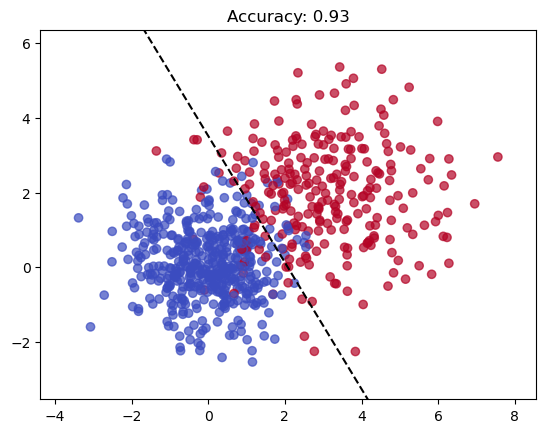

In [38]:
# toy data set with 2 features, and separated classes
df_toy = pd.read_csv('dat/toy_binary.csv')
df_toy

# call fit and plot
model = logreg(penalty='none', fit_intercept=True, solver='lbfgs')
fit_and_plot_decision_boundary(df=df_toy, 
                              model=model, 
                              feature_cols=['X1', 'X2'], 
                              label_col='Y')

- This may not work well if classes are not easily separated by a line (or hyperplane)

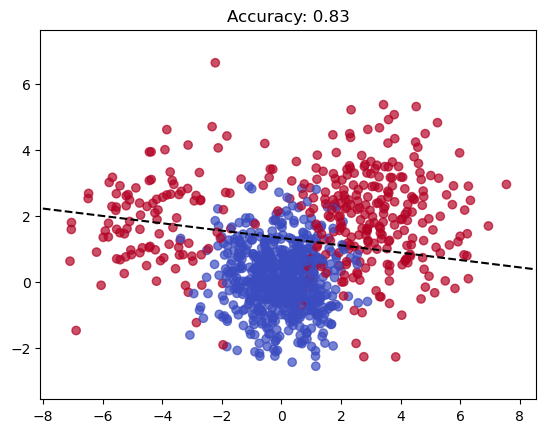

In [39]:
# toy data set with 2 features, and separated classes, but non-linear in x
df_toy_nonlinear = pd.read_csv('dat/toy_binary_nonlinear.csv')

# call fit and plot
model = logreg(penalty='none', fit_intercept=True, solver='lbfgs')
fit_and_plot_decision_boundary(df=df_toy_nonlinear, 
                               model=model, 
                               feature_cols=['X1', 'X2'], 
                               label_col='Y')

### Non-linear decision boundaries
- Logistic regression learns a decision boundary that is linear in $x$

- We can fit it using non-linear transformations $h(x)$

- This will allow it to learn a decision boundary that is linear in $h(x)$ but non-linear in $x$

- For instance, polynomials...

In [40]:
def fit_with_transform_and_plot_non_linear_decision_boundary_on_mesh(df, model, transform=None, feature_cols=['X1', 'X2'], label_col='Y'): 
    """ Plots the decision boundary for a binary classification problem using a non-linear transformation.

    Args:
        df (pd.DataFrame): the dataframe containing the data
        model (scikit-learn model): the model to fit
        transform (function): the non-linear transformation function used to fit the model
    """
    # transform features and fit model
    X = df[feature_cols]
    if transform is not None:
        X = transform(df[feature_cols])
    model.fit(X, df[label_col])

    # calculate accuracy
    y_pred = model.predict(X)
    accuracy = (y_pred == df[label_col]).mean()

    # plot training data
    plt.scatter(df[feature_cols[0]], df[feature_cols[1]], c=df[label_col], cmap='coolwarm', alpha=0.7)
    plt.title(f'Accuracy: {accuracy:.2f}')

    # create meshgrid
    x_grid = np.linspace(df[feature_cols[0]].min(), df[feature_cols[0]].max(), 30)
    y_grid = np.linspace(df[feature_cols[1]].min(), df[feature_cols[1]].max(), 30)
    xax, yax = np.meshgrid(x_grid, y_grid, indexing="ij")

    # create single df with all combinations of x1 and x2
    df_grid = pd.DataFrame({feature_cols[0]: xax.flatten(), feature_cols[1]: yax.flatten()})

    # create non-linear features and predict
    X = df_grid
    if transform is not None:
        X = transform(df_grid)
    preds = model.predict(X)

    plt.scatter(xax, yax, c=preds.flatten(), cmap='coolwarm', s=20, alpha=0.2)
    plt.show()
    return model

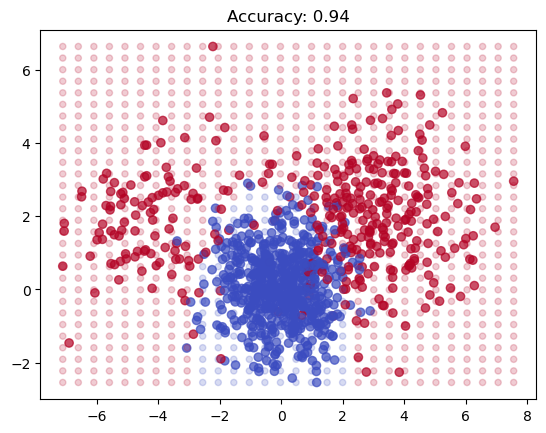

LogisticRegression(penalty='none')

In [41]:
# use scikit learn polynomial features
from sklearn.preprocessing import PolynomialFeatures

# create polynomial features transform
poly = PolynomialFeatures(degree=2, include_bias=False)

# initialize model
model = logreg(penalty='none', fit_intercept=True, solver='lbfgs')

# fit and plot
fit_with_transform_and_plot_non_linear_decision_boundary_on_mesh(df_toy_nonlinear, model, poly.fit_transform)

----
### K nearest neighbors (KNNs)
- Logistic regression is parametric: the dimension of $\beta$ is fixed

- Non-parametric methods allow the complexity of the model class to grow with the training data

- K Nearest Neighbors is an example. When fit to a training data set $(x_i, y_i)_{i=1}^n$ it learns:

$$\begin{align}
P(Y=1 \mid X=x) &= \widehat{p}(x) = \frac{1}{K} \sum_{i \in \textrm{neigh}(x)} y_i \\
\textrm{neigh}(x) &= \textrm{the $K$ training data points whose $x_i$ is ``closest" to $x$}
\end{align}$$

- A fitted KNN model stores all of its training data

- In this sense, non-parametric methods can instead by understood as **massively parametric**


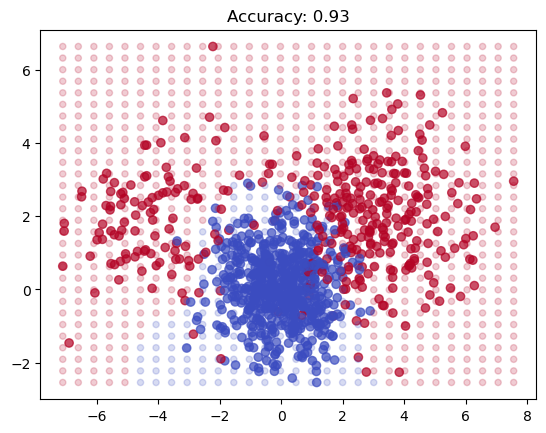

KNeighborsClassifier(n_neighbors=10)

In [42]:
from sklearn.neighbors import KNeighborsClassifier as knn

model = knn(n_neighbors=10)
fit_with_transform_and_plot_non_linear_decision_boundary_on_mesh(df_toy_nonlinear, model)

---
## **Model selection**
- Increasing the polynomial order of our feature transformation let's us fit more and more complex decision boundaries with logistic regression

- Similarly, _decreasing_ the $K$ in KNNs

- Why not fit the most flexible possible model?

- Notice the KNN achieves **zero train error with $K$=1** (by definition)

- Similarly as we increase the polynomial order, logistic regression will achieve zero train error

- Same with regression; higher order polynomials will interpolate the training data:

<img src="img/polynomials.png" width="600" height="">

### Overfitting vs underfitting

- We care about how the model does on unseen data, not train data

- Intuitively: are we **fitting the noise** or **failing to fit the signal**?

<img src="img/Overfitting1Examples.png" width="600" height="">

- Generating a single train-test split, we can see that the error on the test set is lower, particularly when the model class is very complex

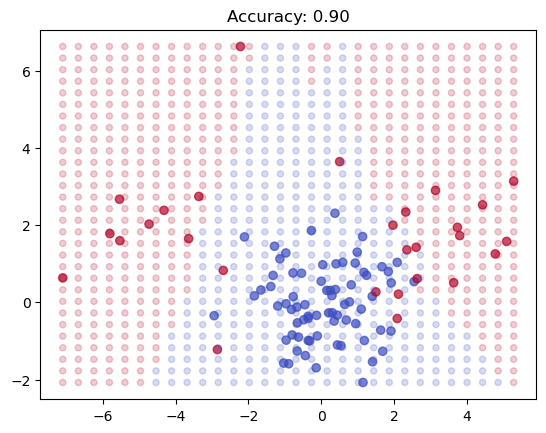

Test accuracy: 0.88


In [44]:
# train test split, with very few training data points
X_train, X_test, y_train, y_test = train_test_split(df_toy_nonlinear[['X1', 'X2']], 
                                                    df_toy_nonlinear['Y'], 
                                                    test_size=0.9)
model = knn(n_neighbors=10)
fitted_model = fit_with_transform_and_plot_non_linear_decision_boundary_on_mesh(pd.concat([X_train, y_train], axis=1), model)

# calculate test accuracy
y_pred = fitted_model.predict(X_test)
accuracy = (y_pred == y_test).mean()
print(f'Test accuracy: {accuracy:.2f}')

### Test error
- The relevant question is **test error** aka
    - "Generalization error"
    - "Out of sample error"
    - "Heldout error"
    - "Prediction error"
    - ...
$$\textrm{Err}(\mathcal{T}) = \mathbb{E}_{X,Y}[\ell(Y, \widehat{Y}(X)) \mid \mathcal{T}]$$

- Here $\mathcal{T} = (X_i, Y_i)_{i=1}^m$ is our training data

- A related quantity (often confused) is the **expected test error**
$$\textrm{Err} = \mathbb{E}_{\mathcal{T}}[\textrm{Err}(\mathcal{T})]$$

- Conceptually we care about test error, but practically expected test error is easier to estimate

- Note that "test error" is overloaded. It may refer to:
    
    - The first definition above (a population average)

    - The second definition (also a population average)

    - An estimate of either of the two above

    - The computed error on a single test set

- Read sections 7.2, 7.4, and 7.12 of [ESL](https://hastie.su.domains/ElemStatLearn/printings/ESLII_print12_toc.pdf)

- Overfitting vs underfitting is defined in terms of **train vs test error**

<img src="img/Overfitting2Error.png" width="500" height="">

- Also see figure 2.4 of [ESL](https://hastie.su.domains/ElemStatLearn/printings/ESLII_print12_toc.pdf)

### Cross validation (CV)
- This suggests a model selection procedure

- Train many models (e.g., KNNs with different values of $K$), evaluate test error, select model with lowest

- How do we use our observed sample $(X_i, Y_i)_{i=1}^n$ to do this most efficiently?

- e.g., a single train-test split may be "unlucky"

- Calculate the **$K$-fold cross validation** error

<img src="img/cv.png" width="500" height="">

- (Note this is a different $K$ than the one in KNNs.)

- When $K=n$, this is called **leave-one-out** error; computationally expensive

- CV error will estimate the "expected test error", and $k=N$ is not necessarily the most statistically efficient way to do this (section 7.12 of [ESL](https://hastie.su.domains/ElemStatLearn/printings/ESLII_print12_toc.pdf))

- In practice $K=5...10$

- Read the [docs](https://scikit-learn.org/stable/modules/cross_validation.html) for scikit-learn's cross validation functionality 

  0%|          | 0/149 [00:00<?, ?it/s]

Text(0.5, 1.0, 'K-fold cross-validation accuracy for different K-neighbors')

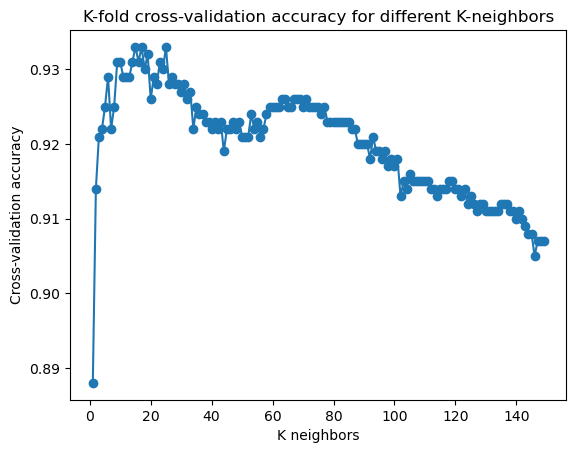

In [45]:
# for displaying progress bars
from tqdm.notebook import tqdm

# estimate cross-validation accuracy for different k
from sklearn.model_selection import cross_val_score

# create a list of k-neighor values
k_values = list(range(1, 150))
# list to store cross-validation accuracy for each k
cv_accuracies = []

for k in tqdm(k_values):
    model = knn(n_neighbors=k)
    cv_accuracy_k = cross_val_score(model, 
                                    df_toy_nonlinear[['X1', 'X2']], 
                                    df_toy_nonlinear['Y'], 
                                    cv=10).mean()
    cv_accuracies.append(cv_accuracy_k)


# plot the cross-validation accuracy for each k
plt.plot(k_values, cv_accuracies, marker='o')
plt.xlabel('K neighbors')
plt.ylabel('Cross-validation accuracy')
plt.title('K-fold cross-validation accuracy for different K-neighbors')


## **Regularization / penalization**
- We see that constraining the model classes can lead to lower test error

- Another approach is to adjust the (model) loss function to **penalize** model complexity

- e.g., a penalized loss function with an $\ell_2$-penalty:

$$\widehat{\beta} \leftarrow \underset{\beta}{\textrm{argmin}} \underbrace{\left[-\sum_{i=1}^n \log P(Y=y_i \mid X=x_i; \beta)\right]}_{\textrm{negative log-likelihood}} + \underbrace{\lambda \sum_{j=1}^p (\beta_j)^2}_{\textrm{$\ell_2$-penalty}}$$

- e.g., linear regression with an $\ell_2$-penalty is called **ridge regression**

In [46]:
# create toy data
n = 100
df_toy_polyreg = pd.DataFrame()
df_toy_polyreg['X'] = x = np.random.uniform(-3, 3, n)
df_toy_polyreg['Y'] = y = 5 * x**3 - x + 2 + np.random.normal(0, 10, n)

/Users/aaronschein/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.09545e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


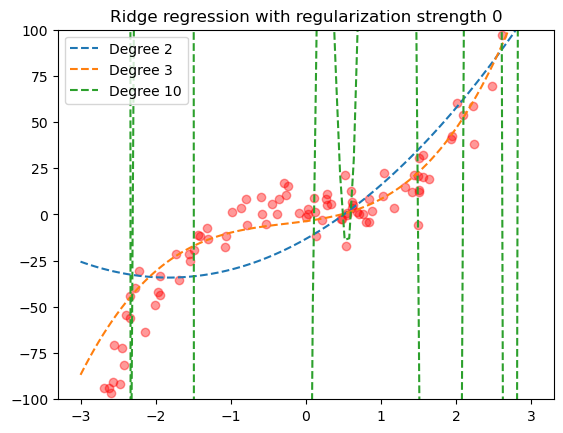

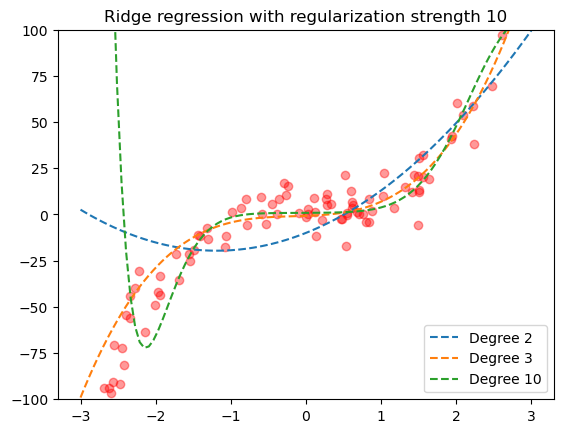

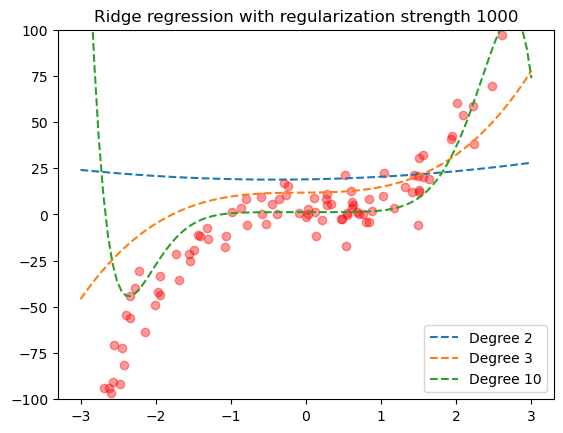

In [47]:
from sklearn.linear_model import Ridge

# set the strength of the regularization
reg_strength = 0

# train on only the first n training points (but plot all)
n_training_points = 10

# plot the data
for reg_strength in [0, 10, 1000]:
    plt.scatter(x, y, alpha=0.4, color='red')
    for degree in [2,3,10]:
        # create linear regression model with l2 regularization and polynomial features
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_transform = poly.fit_transform(x[:, np.newaxis])

        # fit penalized linear regression model
        model = Ridge(fit_intercept=True, alpha=reg_strength)
        model.fit(X_transform[:n_training_points], y[:n_training_points])

        # plot the fitted line
        x_vals = np.linspace(-3, 3, n)
        X_vals = poly.fit_transform(x_vals[:, np.newaxis])
        y_vals = model.predict(X_vals)
        plt.plot(x_vals, y_vals, '--', label=f'Degree {degree}')
    plt.ylim(-100, 100)
    plt.legend()
    plt.title(f'Ridge regression with regularization strength {reg_strength}')
    plt.show()



- e.g., a penalized loss function with an $\ell_1$-penalty:

$$\widehat{\beta} \leftarrow \underset{\beta}{\textrm{argmin}} \underbrace{\left[-\sum_{i=1}^n \log P(Y=y_i \mid X=x_i; \beta)\right]}_{\textrm{negative log-likelihood}} + \underbrace{\lambda \sum_{j=1}^p |\beta_j|}_{\textrm{$\ell_1$-penalty}}$$

- e.g., linear regression with an $\ell_1$-penalty is called **LASSO**

/Users/aaronschein/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.010e+02, tolerance: 2.231e+00
  model = cd_fast.enet_coordinate_descent(


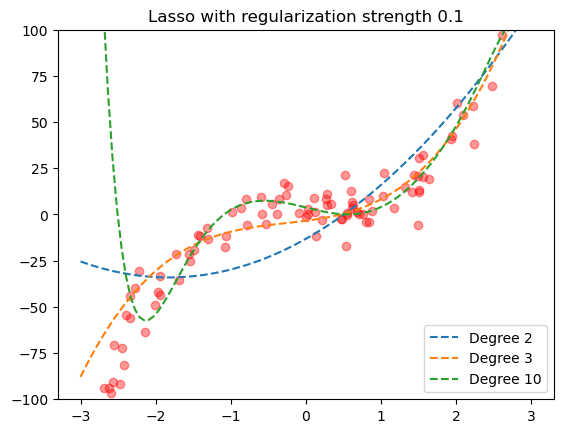

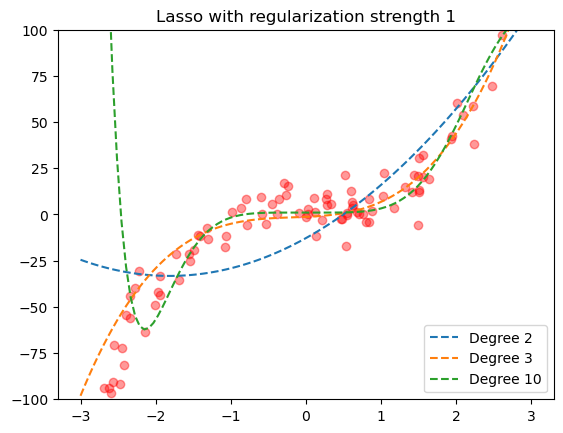

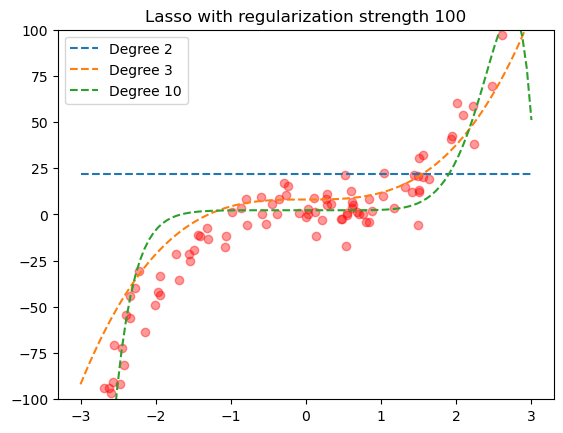

In [48]:
from sklearn.linear_model import Lasso

# set the strength of the regularization
reg_strength = 0

# train on only the first n training points (but plot all)
n_training_points = 10

# plot the data
for reg_strength in [0.1, 1, 100]:
    plt.scatter(x, y, alpha=0.4, color='red')
    for degree in [2,3,10]:
        # create linear regression model with l1 regularization and polynomial features
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_transform = poly.fit_transform(x[:, np.newaxis])

        # fit penalized linear regression model
        model = Lasso(fit_intercept=True, alpha=reg_strength, max_iter=100000)
        model.fit(X_transform[:n_training_points], y[:n_training_points])

        # plot the fitted line
        x_vals = np.linspace(-3, 3, n)
        X_vals = poly.fit_transform(x_vals[:, np.newaxis])
        y_vals = model.predict(X_vals)
        plt.plot(x_vals, y_vals, '--', label=f'Degree {degree}')
    plt.ylim(-100, 100)
    plt.legend()
    plt.title(f'Lasso with regularization strength {reg_strength}')
    plt.show()



- $\ell_2$ vs $\ell_1$ penalties will select different solutions

- $\ell_1$ solutions are **sparse** while $\ell_2$ solutions are **shrunk**


<img src="img/fig_3_11_ESL.png" width="600" height="">

- There many other kinds of regularizers, e.g.,

    - Elastic net (combination of $\ell_1$ and $\ell_2$ penalty)

    - ...

### Bias-variance tradeoff

- Regularizers can be undersood as encoding **inductive biases**

- A regularizer introduces **bias** in model estimation

- Define $\widehat{Y}(\,\cdot\,\,; \mathcal{T})$ to be the decision rule that we obtain by fitting to training data $\mathcal{T}$

- Define the mean squared error (MSE) on a **fixed test point** $(x_0, y_0)$:

$$\textrm{MSE}(\widehat{Y}, x_0, y_0) = \mathbb{E}_\mathcal{T}[(y_0 - \widehat{Y}(x_0; \mathcal{T}))^2]$$

- Note: we are averaging over training data sets $\mathcal{T}$.

- The well-known **bias-variance decomposition** of this expression is

$$\begin{align}
\textrm{MSE}(\widehat{Y}, x_0, y_0) &= \mathbb{E}_\mathcal{T}\left[\Big(y_0 - \widehat{Y}(x_0; \mathcal{T})\Big)^2\right] \\
&= \underbrace{\left(\mathbb{E}_\mathcal{T}[\widehat{Y}(x_0; \mathcal{T})] - y_0\right)^2}_{\textrm{Bias}^2} + \underbrace{\mathbb{E}_\mathcal{T}\left[\Big(\widehat{Y}(x_0; \mathcal{T}) - \mathbb{E}_\mathcal{T}[(\widehat{Y}(x_0; \mathcal{T})]\Big)^2\right]}_{\textrm{Variance}}
\end{align}
$$

- Intuitively, constraining the model class introduces bias, but it may still decrease test error if it also decreases variance

<img src="img/bullseye.png" width="400" height="">

- Another (more complicated) picture

<img src="img/fig_7_2_ESL.png" width="400" height="">